# 1) Fundamentos de Paralelismo y Concurrencia (Conceptos)



### CPU (Unidad Central de Procesamiento)
La CPU es el cerebro de la computadora donde la mayoría de los cálculos ocurren. En términos simples, es lo que permite a tu computadora ejecutar programas y aplicaciones.

### Núcleo (Core)
Un núcleo es una parte de la CPU que puede trabajar en problemas de manera independiente de los otros núcleos. En otras palabras, si tienes una CPU de cuatro núcleos, puede trabajar en cuatro tareas al mismo tiempo.

### Hilo (Thread)
Un hilo es la unidad más pequeña de procesamiento que puede ser gestionada por un sistema operativo. Cada hilo puede ejecutar partes diferentes de un programa, permitiendo la multitarea. En Python, el módulo `threading` se usa para crear y manejar hilos para un control de bajo nivel, de manera mas abstracta puedes usar el modulo `concurrent.futures`.

### Proceso
Un proceso es una instancia de un programa en ejecución. Puede contener uno o más hilos. Cada proceso tiene su propio espacio de memoria, lo que significa que un proceso no puede acceder directamente a los datos de otro proceso sin un método de comunicación interproceso.

### Paralelismo
El paralelismo es una técnica donde múltiples tareas se ejecutan al mismo tiempo. Esto se logra dividiendo un problema en partes independientes que pueden ser ejecutadas simultáneamente. En Python, puedes lograr paralelismo usando el módulo `multiprocessing` para un control de bajo nivel, de manera mas abstracta puedes usar el modulo `concurrent.futures`.

### Concurrencia
La concurrencia se refiere a la habilidad de un programa de manejar múltiples tareas, pero no necesariamente al mismo tiempo. Un programa concurrente puede estar trabajando en más de una tarea en un momento dado, pero puede o no estar ejecutando las tareas simultáneamente.

### Paralelismo Vs Concurrencia
Aunque estas dos palabras se usan a menudo indistintamente, no son exactamente lo mismo. La concurrencia es cuando dos tareas pueden iniciar, correr y completar en tiempos superpuestos; el paralelismo es cuando las tareas literalmente corren al mismo tiempo. La diferencia radica en el hecho de que, aunque ambos pueden tener múltiples tareas en progreso al mismo tiempo, solo el paralelismo implica la ejecución simultánea de tareas.

|                      | Hilos                            | Procesos                               |
|----------------------|----------------------------------|----------------------------------------|
| Costo de Inicialización | Bajo                             | Alto                                   |
| Manejado por         | Intérprete de CPython            | Sistema Operativo                      |
| Acceso a la memoria  | Compartida                       | Espacios de memoria separados          |
| Ejecución            | Concurrente (NO paralela)        | Concurrente y/o Paralela               |


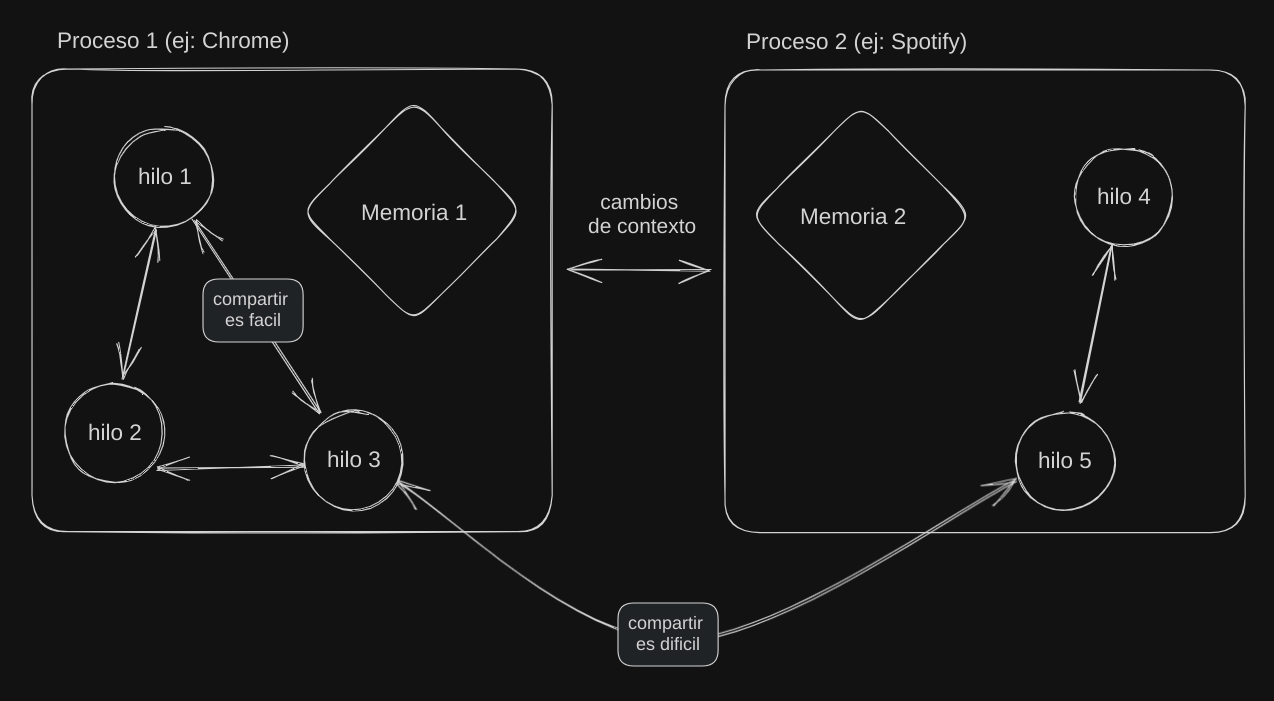

## Programas sin espera de I/O
- El paralelismo ayudara a reducir tiempos
- Concurrencia sin paralelismo no ayuda a reducir tiempos (por el GIL que veremos mas adelante), o en otras palabras... si solo tenemos un nucleo no podremos reducir el tiempo.


En la siguiente imagen cada circulo de color es un hilo especifico y cada  circulo seria un pedazo de codigo que tarda 1 segundo en ejecutarse.

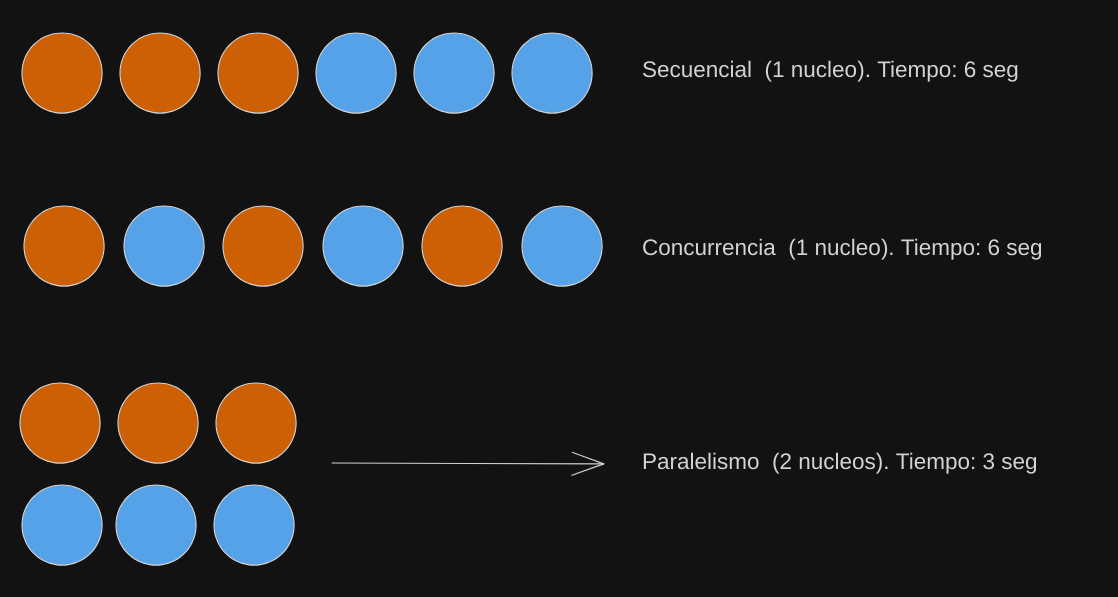

## Programas con espera de I/O
- El paralelismo ayudara a reducir tiempos
- Concurrencia sin paralelismo igual ayuda a reducir tiempos.


En la siguiente imagen cada color es un hilo especifico:
- el color solido representa un pedazo de codigo que tarda 1 segundo en ejecutarse.
- el color rayado representa un tiempo de espera I/O de 1 segundo en el codigo.


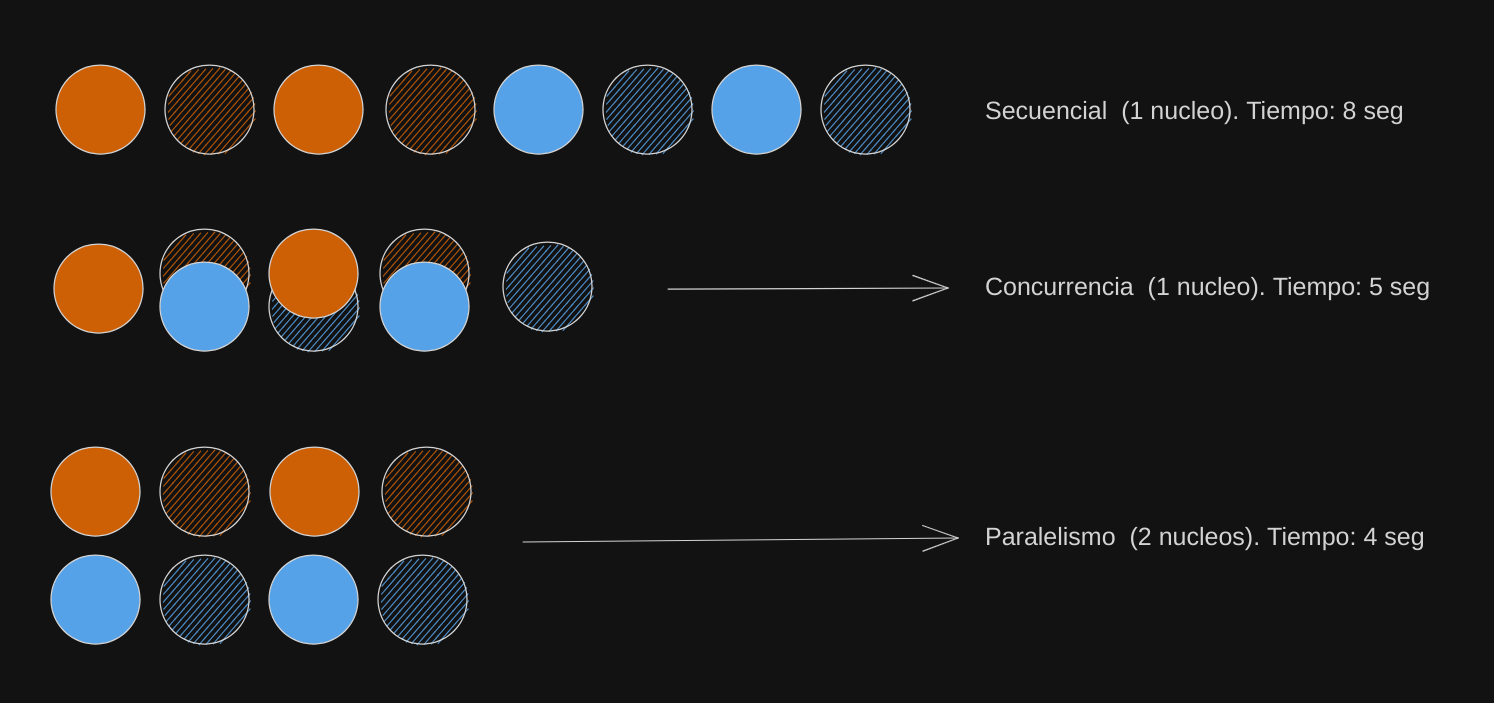

### Lo mas optimo seria aplicar ambos al mismo tiempo:

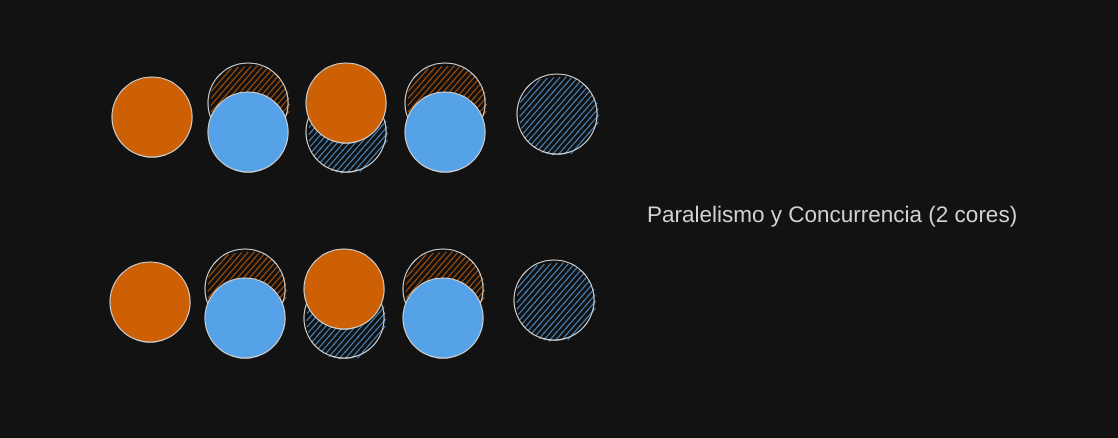

## Cuándo usar cada uno en Python
Depende del problema que estés tratando de resolver. Si tienes tareas que pueden ejecutarse de manera independiente y quieres mejorar el rendimiento aprovechando múltiples núcleos de la CPU, el paralelismo (mediante 'multiprocessing') sería la opción a elegir. Si estás trabajando con IO (Input/Output) - tareas limitadas (como descarga de archivos, leer/escribir a base de datos, etc.), o donde la comunicación entre las tareas es importante, entonces la concurrencia (mediante 'threading' o 'asyncio' para programación asíncrona) sería más útil.

---
# 2) Implementando Concurrencia en Python (Hilos)




### Global Interpreter Lock

El **Global Interpreter Lock (GIL)** es una característica de CPython, la implementación más común de Python. Su función principal es prevenir que múltiples hilos nativos ejecuten bytecodes de Python simultáneamente en un mismo proceso, protegiendo así la memoria y las estructuras de datos de Python de potenciales inconsistencias. El GIL fue diseñado en una era donde predominaban los sistemas de computadoras con un solo núcleo y aunque este mecanismo simplifica la programación y ayuda a evitar errores complejos de concurrencia, también limita la capacidad de los programas de Python con múltiples hilos de beneficiarse de los sistemas con múltiples núcleos, **permitiendo que solo un hilo se ejecute a la vez en el intérprete Python.**

---


❗❗ Esto es importante para entender que en Python los hilos de un mismo proceso solo se ejecutaran de manera concurrente y nunca simultaneamente (en paralelo).



### Implementacion con `threading`

In [ ]:
import threading as th
import time

#### Ejemplo 1: Concurrencia en la vida real
Demostremos de manera intuitiva que manejar hilos en python permite la concurrencia de multihilos, pero nunca la ejecucion simultanea.

In [ ]:
th.current_thread().name

In [ ]:
th.active_count()

In [ ]:
%%time
def comer_desayuno():
    print("desayunando\n")
    time.sleep(3)
    print("Has terminado de desayunar.\n")


def beber_cafe():
    print("bebiendo cafe\n")
    time.sleep(4)
    print("Has terminado tu taza de cafe.\n")


def leer_el_resumen():
    print("leyendo el resumen\n")
    time.sleep(5)
    print("Has terminado de leer el resumen.\n")





In [ ]:
comer_desayuno()
beber_cafe()
leer_el_resumen()

In [ ]:
hilo_1 = th.Thread(target=comer_desayuno)
hilo_2 = th.Thread(target=beber_cafe)
hilo_3 = th.Thread(target=leer_el_resumen)

hilo_1.start()
hilo_2.start()
hilo_3.start()

hilo_1.join()
hilo_2.join()
hilo_3.join()


#### Nota importante con respecto a multithreading en google colab

Cuando ejecutes una celda en google colab con varios hilos y en alguno de los hilos tengas tiempo de espera puede que no observes los prints que hagas en dichos hilos en el output de la celda, no es el caso si corres el codigo desde un archivo de python.

#### Ejemplo 2: Condicion de Carrera

Una de los problemas que pueden surgir al trabajar con multihilos es la llamada condicion de carrera, es basicamente cuando dos o mas hilos al no sincronizarse adecuadamente, y se da la situacion en que uno de los hilos lee el valor de una variable compartida antes de que otro hilo haya terminado de actualizarla.

In [ ]:
%%writefile hilos_carrera.py
import threading as th
import time

contador_global = 0

def incrementar_contador(numero):
    global contador_global

    contador_local = contador_global # leer el valor
    contador_local += numero # modifico el valor
    time.sleep(0.5) # tiempo de espera -> dar la condicion de carrera
    contador_global = contador_local # actualizo el valor


hilo1 = th.Thread(target=incrementar_contador, args=(70,))
hilo2 = th.Thread(target=incrementar_contador, args=(30,))
hilo3 = th.Thread(target=incrementar_contador, args=(10,))

hilo1.start()
hilo2.start()
hilo3.start()

hilo1.join()
hilo2.join()
hilo3.join()

print(contador_global)

In [ ]:
for _ in range(50):
    !python hilos_carrera.py

#### Ejemplo 3: Sincronizando hilos con Locks

Un Lock es un objeto que permitira darle prioridad a la ejecucion de un hilo para evitar cosas como la condicion de carrera.

En otras palabras un Lock permite que los hilos tengan una operacion "atomica" (aunque no en el sentido estricto), esto ultimo quiere decir que la ejecucion del hilo con el Lock se ejecutara sin que otros hilos interfieran.

In [ ]:
# ejercicio sincronizando los hilos para vencer la condicion de carrera
%%writefile hilos_sincronizados.py
import threading as th
import time

contador_global = 0
lock = th.Lock()

def incrementar_contador(numero, lock):  # Añadir el lock como un argumento
    global contador_global
    with lock:
        contador_local = contador_global
        contador_local += numero
        time.sleep(0.5)
        contador_global = contador_local


hilo1 = th.Thread(target=incrementar_contador, args=(70, lock))  # Pasar el lock como argumento
hilo2 = th.Thread(target=incrementar_contador, args=(30, lock))
hilo3 = th.Thread(target=incrementar_contador, args=(10, lock))

hilo1.start()
hilo2.start()
hilo3.start()

hilo1.join()
hilo2.join()
hilo3.join()

print(contador_global)


In [ ]:
!python hilos_sincronizados.py

#### Ejemplo 4: Hilos tipo Daemon

Los hilos Daemon son hilos que se ejecutan en segundo plano y no impiden la terminacion del programa. Por defecto Python esperara que todos los hilos (de tipo no Daemon) terminen sus ejecuciones antes de terminar el programa.

Los hilos Daemon son particularmente utiles en los casos en los que tenemos un ciclo infinito, un hilo que no necesita tener una limpieza antes de la terminacion del programa o un tarea no critica.

En este ejemplo queremos contar el tiempo de ejecucion de un programa que pide una entrada del usuario.

In [ ]:
import threading as th
import time

def contador_segundos():
    conteo = 0
    while True:
        time.sleep(1)
        conteo += 1
        print("\nTiempo en ejecucion: ", conteo, "segundos")

hilo_daemon = th.Thread(target=contador_segundos, daemon=True, name="Daemon-Ejemplo")
hilo_daemon.start()

nombre = input("Cual es tu nombre?")
print(f"Hola {nombre}")


### Implementacion con `concurrent.futures`

Python tambien tiene esta libreria que proporciona una interfaz de mas alto nivel y esto lo puede hacer mas facil de usar, por ejemplo no necesitas llamada a join explicitamente.

In [ ]:
from concurrent.futures import ThreadPoolExecutor

In [ ]:
#%%writefile hilos_pool.py
from concurrent.futures import ThreadPoolExecutor
import time

def comer_desayuno():
    print("desayunando\n")
    time.sleep(3)
    print("Has terminado de desayunar.\n")

def beber_cafe():
    print("bebiendo cafe\n")
    time.sleep(4)
    print("Has terminado tu taza de cafe.\n")

def leer_el_resumen():
    print("leyendo el resumen\n")
    time.sleep(5)
    print("Has terminado de leer el resumen.\n")

# Crea un ThreadPoolExecutor
with ThreadPoolExecutor() as thread_manager:
    # Inicia cada función en un hilo separado
    thread_manager.submit(comer_desayuno)
    thread_manager.submit(beber_cafe)
    thread_manager.submit(leer_el_resumen)

print("Todos los hilos han terminado.")


In [ ]:
!python hilos_pool.py

---
# 3) Implementando Paralelismo en Python (Procesos)



A diferencia de la seccion anterior, en esta seccion aprenderemos a ejecutar tareas en simultaneo y el GIL no sera un problema. Lo unico que limitara sera la cantidad de nucleos que tengamos.

Para lograr el paralelismo usamos la libreria `multiprocessing` para crear varias instancias (es decir varios procesos) del interprete de Python (cada una con su propio GIL) en donde distibuiremos la carga de nuestro programa.

In [ ]:
import multiprocessing as mp
import time

In [ ]:
mp.cpu_count()

### Ejemplo 1 `multiprocessing`: Paralelismo en la vida real

In [ ]:
def hablar_por_llamada():
    print("Atendiste una llamada...\n")
    time.sleep(4)
    print("Sigues Hablando...\n")
    time.sleep(2)
    print("Ha finalizado la llamada.\n")


def caminar_por_la_calle():
    print("Comienzas a caminar...\n")
    time.sleep(4)
    print("Estas caminando..\n")
    time.sleep(2)
    print("Sigues caminando.\n")
    time.sleep(3)
    print("Dejaste de caminar.\n")




#### Sin multiprocesamiento


In [ ]:
%%time
hablar_por_llamada()
caminar_por_la_calle()

#### Con multiprocesamiento

In [ ]:
%%time

p1 = mp.Process(target=hablar_por_llamada)
p2 = mp.Process(target=caminar_por_la_calle)

p1.start()
p2.start()

p1.join()
p2.join()


### Ejemplo 2 `multiprocessing`: Multiprocesamiento con Pool

In [ ]:
import time
import os
import requests
import multiprocessing as mp


def bajar_datos(url):
    worker_pid = os.getpid()
    cpu_affinity = os.sched_getaffinity(worker_pid)
    print(f"{worker_pid} está llamando a la URL: {url}, puede usar algun nucleo de: {cpu_affinity}\n")
    time.sleep(1)
    return requests.get(url).text

# En este ejemplo intento bajar varios datos del sitio web numbersapi.com

urls = [f"http://numbersapi.com/{number}" for number in [1,2,3,4,5,6,7,8]]
print(urls)

#### Sin Multiprocesamiento

In [ ]:
%%time
# De esta manera voy bajando los dato de a uno
for url in urls:
    resultado = bajar_datos(url)
    print(resultado)

#### Con Multiprocesamiento

In [ ]:
%%time
# De esta manera hago todo al mismo tiempo, en paralelo

with mp.Pool(processes=None) as pool:
    print(pool.map(bajar_datos, urls))

Sin embargoe existe la posibilidad de colocar mas procesos que nucleos en nuestra computadora esto se debe a

In [ ]:
%%time

with mp.Pool(processes=8) as p:
    print(p.map(bajar_datos, urls))

### Ejemplo 3 `concurrent.futures`:

In [ ]:
from concurrent.futures import ProcessPoolExecutor, as_completed
import os
import time
import requests

In [ ]:
def bajar_datos(url):
    worker_pid = os.getpid()
    cpu_affinity = os.sched_getaffinity(worker_pid)
    print(f"{worker_pid} está llamando a la URL: {url}, puede usar algun nucleo de: {cpu_affinity}\n")
    time.sleep(1)
    return requests.get(url).text

# En este ejemplo intento bajar varios datos del sitio web numbersapi.com

urls = [f"http://numbersapi.com/{number}" for number in [1,2,3,4,5,6,7,8]]

In [ ]:
with ProcessPoolExecutor(max_workers=8) as executor:
    results = [executor.submit(bajar_datos, url) for url in urls]

In [ ]:
with ProcessPoolExecutor(max_workers=8) as executor:
    results = executor.map(bajar_datos, urls)


### Recomendaciones finales y desventajas


**Recomendaciones**:

- numpy, scipy, tensor flow y otras librerias relacionadas a los computos matematicos ya usan multihilos de manera simultanea, usar concurrencia o paralelismo no seria una notable ayuda, investiga bien el mecanismo subyacente de las funciones y/o metodos que estes usando de este tipo de librerias antes.

- siempre que se pueda evita usar el objeto `Process` y usa en su lugar el objeto `Pool` o `ProcessPoolExecutor`

- cada proceso tiene su propio Global Interpreter Lock (GIL)


**Desventajas**:

- Usar multiprocesamiento en la situacion en la cual el costo de crear procesos y comunicarlos entre ellos es mayor que el costo de solo hacer el procesamiento, es lo que se llama cambio de contexto (context switching)... aplica solo multiprocesamiento a cosas que ya tomen mucho tiempo.

- Enviar o recibir tipos de datos a traves de los Procesos que no sean serializables por Pickle.

- Enviar demasiada data, con mucha data habria una gran carga, siempre que se pueda se debe enviar informacion de como crear la data desde el proceso en si (ej: en vez de enviar un archivo, enviar la ruta al mismo)

- no optimizar el chunksize (el chunksize es la cantidad de Tareas que toma cierto proceso para ejecutar), mientras mas grande sea el chunksize menos tranferencias de dato habra entre el host (Pool) y el worker, pero un chunk mas grande tambien implica copiar mas datos para luego ser enviados lo cual podria hacer que te quedes sin memoria (para esto es mejor usar imap o imap_unorderer)

    ```python
    with mp.Pool(processes=8) as p:
        print(p.map(bajar_datos, urls, chunksize=10))
    ```


---
# 4) Comunicacion entre Procesos/Hilos



### Ejemplo 1: Queue.

#### Procesos

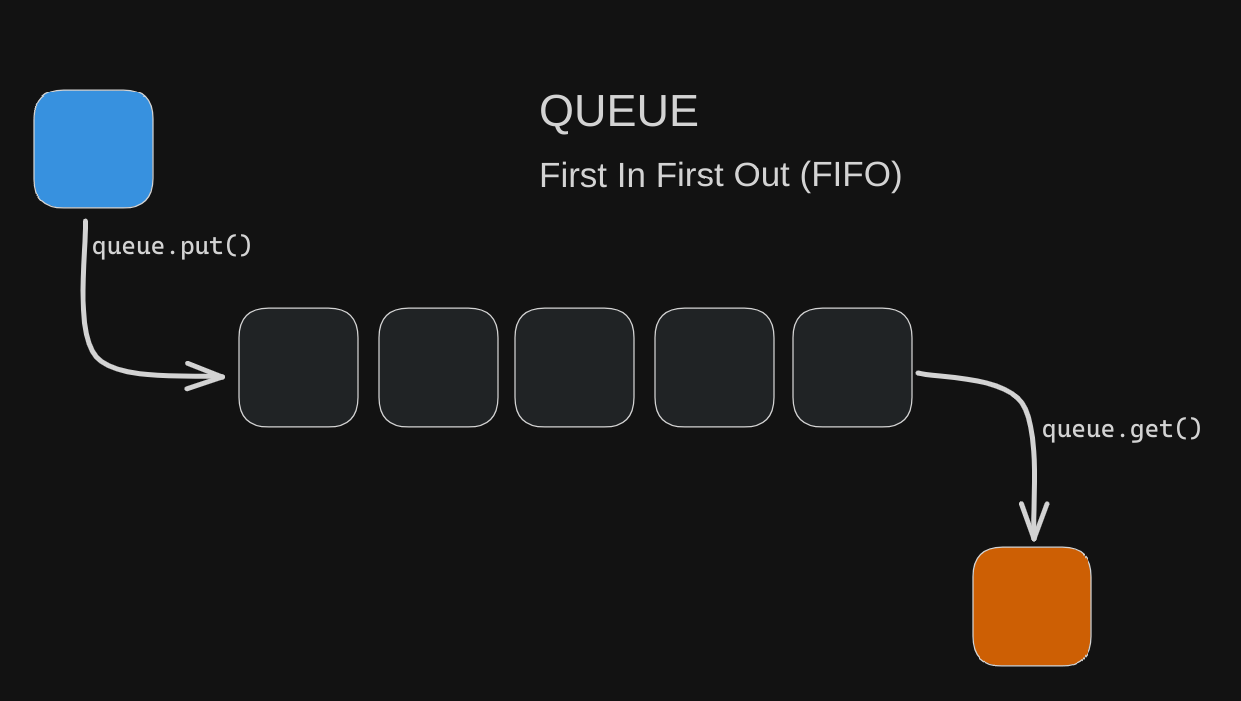

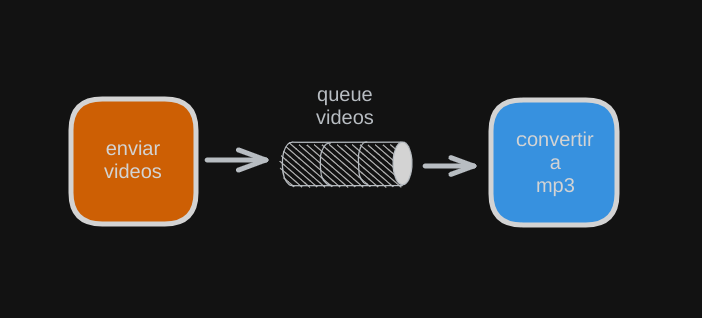

In [ ]:
import multiprocessing as mp

def enviar_video(videos, queue):
    for video in videos:
        queue.put(video)

def convertir_a_mp3(queue):
    while not queue.empty():
        print(f"Convirtiendo {queue.get()} a mp3. ")

videos = [
    "lenguajes_programacion_mejor_pagados.mp4",
    "top_10_goles_messi.mp4",
    "videos_gatitos_graciosos.mp4",
    ]

queue = mp.Queue()

proceso_enviar_video =  mp.Process(target=enviar_video, args=(videos, queue))
proceso_convertir_mp3 = mp.Process(target=convertir_a_mp3, args=(queue,))

proceso_enviar_video.start()
proceso_convertir_mp3.start()

proceso_enviar_video.join()
proceso_convertir_mp3.join()

#### Hilos

In [ ]:
import threading
import queue

def enviar_video(videos, queue):
    for video in videos:
        queue.put(video)

def convertir_a_mp3(queue):
    while not queue.empty():
        print(f"Convirtiendo {queue.get()} a mp3. ")

videos = [
    "lenguajes_programacion_mejor_pagados.mp4",
    "top_10_goles_messi.mp4",
    "videos_gatitos_graciosos.mp4",
]

q = queue.Queue()

hilo_enviar_video = threading.Thread(target=enviar_video, args=(videos, q))
hilo_convertir_mp3 = threading.Thread(target=convertir_a_mp3, args=(q,))

hilo_enviar_video.start()
hilo_convertir_mp3.start()

hilo_enviar_video.join()
hilo_convertir_mp3.join()


### Ejemplo 3: Compartiendo una Variable


#### Entre procesos

Entre Procesos no se comparte el mismo espacio de memoria


`multiprocessing.Value` es una forma de crear una variable de datos que puede ser compartida entre varios procesos. Este tipo de variable es útil cuando necesitas que varios procesos lean o actualicen el mismo valor. Por ejemplo, podrías usar `multiprocessing.Value` para contar cuántas tareas han sido completadas por un grupo de procesos, o para mantener una bandera que indique si un proceso debe continuar trabajando.

`multiprocessing.Value` toma dos argumentos. El primero es una cadena que indica el tipo de dato de la variable (por ejemplo, 'i' para un entero, 'd' para un número de doble precisión). El segundo argumento es el valor inicial de la variable.

In [ ]:
%%time
import multiprocessing as mp
import time

def count_a(text, counter):
    time.sleep(2)
    with counter.get_lock():
        counter.value += text.count('a')

texts = [
    "A veces es necesario cambiar de dirección para poder avanzar. Amamos la vida.",
    "Aunque el mar sea tranquilo, no significa que los peces duerman. Avanza.",
    "Adelante, porque el camino es largo y aún tenemos mucho por recorrer. Anda.",
]

counter = mp.Value('i', 0)  # 'i' significa que es un entero y 0 seria el valor inicial del contador

processes = []

for text in texts:
    process = mp.Process(target=count_a, args=(text, counter))
    processes.append(process)

for process in processes:
    process.start()

for process in processes:
    process.join()

print(f"La letra 'a' apareció {counter.value} veces en total.")


In [ ]:
' '.join(texts).count('a')

#### Entre hilos

Entre hilos si se comparte el mismo espacio de memoria

In [ ]:
import threading

# Esta es la variable compartida
info = {"contador": 0}
# Este es el bloqueo que protegerá la variable compartida
lock = threading.Lock()

def worker(info):
    with lock:
        temp = info
        info["contador"] = temp["contador"] + 1

# Crear y lanzar los hilos
threads = []
for _ in range(100):
    thread = threading.Thread(target=worker, args=(info,))
    thread.start()
    threads.append(thread)

# Esperar a que todos los hilos terminen
for thread in threads:
    thread.join()

print(f"El contador es {info['contador']}")


### Caso concurrent.futures

Los ejecutores de la biblioteca `concurrent.futures` (como `ThreadPoolExecutor` y `ProcessPoolExecutor`) no admiten el uso compartido directo de memoria entre trabajos.